In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
import re

In [2]:
df = pd.read_csv('./train/FW_base_v1.csv', index_col = 0)

obj_columns = df.select_dtypes(include=['object']).columns
# Apply one-hot encoding to object columns
df = pd.get_dummies(df, columns = obj_columns, drop_first = True)

y = df.TARGET
X = df.drop('TARGET', axis = 1)

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.05, random_state = 37)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 1/19, random_state = 37)

data_dmatrix = lgb.Dataset(data=X_train,label=y_train)

In [3]:
#  num_leaves = 2^(max_depth)
params = {
            # 'boosting_type': 'gbdt', 'scale_pos_weight' : 14,
            # 'learning_rate': 0.1,'reg_alpha' : 0 , 'random_state' : 37, 
            # 'early_stopping_rounds':20, 'max_depth' : 5, 'num_leaves' : 31
            # }
            'boosting_type':'gbdt', 'class_weight':'balanced', 'colsample_bytree':1.0,
            'importance_type':'split', 'learning_rate':0.1, 'max_depth':-1,
            'min_child_samples':20, 'min_child_weight':0.001, 'min_split_gain':0.0,
            'n_estimators':100, 'device':'gpu', 'num_leaves':31, 'objective':"binary",
            'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True,  'early_stopping_rounds': 20,
            'subsample':1.0, 'subsample_for_bin':200000, 'subsample_freq':0}

pipe_lgb = Pipeline([('scaler', StandardScaler()), ('lgb', lgb.LGBMClassifier(**params))])

t0 = time.time()
pipe_lgb.fit(X_train.values, y_train.values,
            lgb__eval_set = [(X_train.values, y_train.values), (X_test.values, y_test.values)],
            lgb__eval_names = ['train', 'val'],
            lgb__eval_metric = 'binary_error',
            )
t1 = time.time()
y_pred = pipe_lgb.predict(X_test)
y_trainPred = pipe_lgb.predict(X_train)
print('LightGBM elapse time: {}'.format(t1-t0))

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 23492, number of negative: 267834
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3684
[LightGBM] [Info] Number of data points in the train set: 291326, number of used features: 134
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 630, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 23 dense feature groups (6.67 MB) transferred to GPU in 0.013801 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stop

c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: silent
LightGBM elapse time: 4.184848308563232


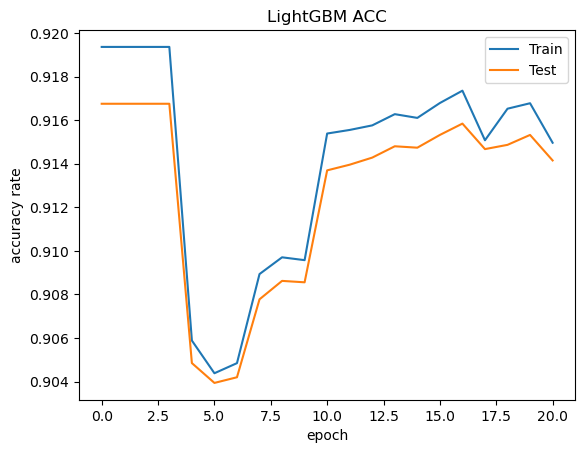

In [10]:
# accuracy=accuracy_score(y_pred, y_test)
# print('LightGBM Model test accuracy score: {0:0.4f}'.format(accuracy))

results = pipe_lgb.named_steps["lgb"].evals_result_
epochs = len(results['train']['binary_error'])
x_axis = range(0, epochs)
acc = [np.abs(x - 1) for x in results['train']['binary_error']]
acc2 = [np.abs(x - 1) for x in results['val']['binary_error']]
fig, ax = plt.subplots()
ax.plot(x_axis, acc, label='Train')
ax.plot(x_axis, acc2, label='Test')
ax.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy rate')
plt.title('LightGBM ACC')
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0]) # 實際沒違約，預測正確
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0]) # 實際違約，預測卻沒有

Confusion matrix

 [[9456 4640]
 [ 466  814]]

True Positives(TP) =  9456

True Negatives(TN) =  814

False Positives(FP) =  4640

False Negatives(FN) =  466


<Axes: >

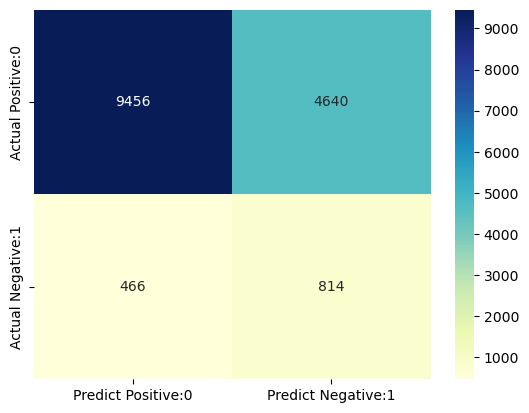

In [7]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Positive:0', 'Predict Negative:1'], 
                                 index=['Actual Positive:0', 'Actual Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.67      0.79     14096
           1       0.15      0.64      0.24      1280

    accuracy                           0.67     15376
   macro avg       0.55      0.65      0.51     15376
weighted avg       0.89      0.67      0.74     15376



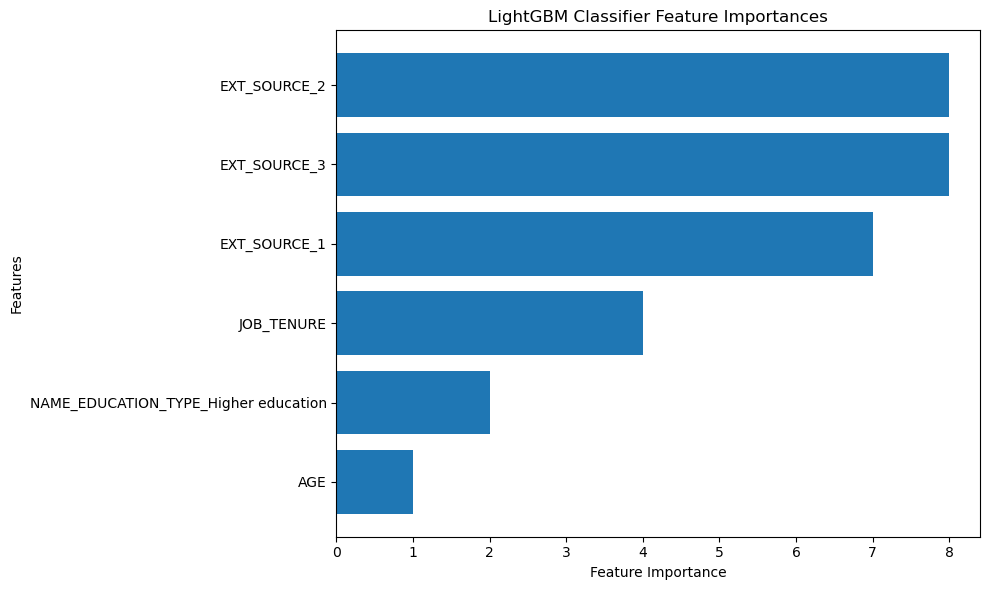

In [9]:
feature_importances = pipe_lgb.steps[1][1].feature_importances_
# Get feature names from the pipeline
feature_names = X_train.columns

# Sort feature importances in ascending order
sorted_indices = np.argsort(feature_importances)[::1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

important_indices = np.where(sorted_feature_importances != 0)[0]
important_feature_importances = sorted_feature_importances[important_indices]
important_feature_names = sorted_feature_names[important_indices]
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(important_feature_importances)), important_feature_importances, tick_label=important_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('LightGBM Classifier Feature Importances')
plt.tight_layout()
plt.show()